In [28]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,Column
from tqdm import notebook
from astropy import units
import emcee
from mpmath import expint, mp
from scipy.optimize import minimize
from lightkurve.search import search_lightcurve

%load_ext autoreload
%autoreload 2
from astroquery.mast import Catalogs
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord

import stella

sys.path.append('/Users/arcticfox/Documents/GitHub/flares_soc/scripts')
from tools import *

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3
lw = 5

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
parula = np.load('/Users/arcticfox/parula_colors.npy')

from matplotlib.colors import LinearSegmentedColormap

parula_colors = np.load('/Users/arcticfox/parula_colors.npy')
parula_map = LinearSegmentedColormap.from_list('parula', parula_colors[:220])

samples_short = np.load('/Users/arcticfox/Downloads/short_period.npy')
samples_long = np.load('/Users/arcticfox/Downloads/long_period.npy')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
parula = np.load('/Users/arcticfox/parula_colors.npy')

mgun = Table.read('/Users/arcticfox/Documents/flares/criticality/all_star_param_catalog.tab',
                  format='ascii')

allflares = Table.read('/Users/arcticfox/Documents/flares/criticality/all_flares_param_catalog.tab', 
                       format='csv')

filters = [i for i in allflares.colnames if 'passed_' in i]
allflares = allflares[(allflares[filters[0]]=='True')&
                      (allflares[filters[1]]=='True')&
                      (allflares[filters[2]]=='True')&
                      (allflares[filters[3]]=='True')]

In [4]:
fakenews = 231799463
badinds = np.where(allflares['TIC_ID']==fakenews)[0]
badinds2= np.where(mgun['TIC_ID']==fakenews)[0]8
allflares.remove_rows(badinds)
mgun.remove_row(badinds2[0])

In [4]:
f20 = Table.read('feinstein2020.txt', format='ascii')
h20 = Table.read('howard20.txt', format='csv')

tics = np.append(f20['TIC'],h20['tic_id'])
rots = np.append(f20['period_days'], h20['p_rot'])

_,args=np.unique(tics,return_index=True)
tics=tics[args]
rots=rots[args]

In [5]:
mgun_rots = np.zeros(len(mgun))
missing=np.array([],dtype=int)

for i in range(len(tics)):
    ind = np.where(mgun['TIC_ID']==tics[i])[0]
    if len(ind)>0:
        mgun_rots[i] = rots[i]
    else:
        missing=np.append(missing,tics[i])

### Find the missing targets

In [6]:
ndat = np.load('more_targets.npy', allow_pickle=True)
flare_table = Table.read('new_flares.tab', format='ascii')

In [10]:
lks = []

for tic in np.unique(flare_table['Target_ID']):
    s = search_lightcurve('TIC {}'.format(int(tic)), author='SPOC',
                          exptime=120, mission='TESS')
    d = s[s.year<2020][0].download_all()
    lks.append(d)

In [11]:
tcolnames = ['ID','ra', 'dec', 'Teff', 'Tmag', 'd', 'Hmag','Jmag', 'Kmag']
gcolnames = ['teff_val', 'teff_percentile_lower', 'phot_rp_mean_mag', 'phot_bp_mean_mag',
             'phot_g_mean_mag', 'bp_rp','lum_val','radius_val']

In [7]:
for i in range(len(lks)):
    row_mgun = np.zeros(len(mgun.colnames))
    row_allflares = np.zeros(len(allflares.colnames))
    
    output_t = Catalogs.query_region(SkyCoord(lks[i][0].meta['RA_OBJ'],
                                            lks[i][0].meta['DEC_OBJ'], unit=units.deg),
                                   radius=0.1,
                                   catalog='TIC')[0]
    
    for j,k in enumerate([0,2,3,4,5,6,-3,-2,-1]):
        row_mgun[k] = output_t[tcolnames[j]]
        
    row_mgun=row_mgun.tolist()
    row_mgun[1]=''
    row_mgun[7]=''
    mgun.add_row(row_mgun)
    
    output_g = Catalogs.query_region(SkyCoord(lks[i][0].meta['RA_OBJ'],
                                            lks[i][0].meta['DEC_OBJ'], unit=units.deg),
                                   radius=0.1,
                                   catalog='Gaia', version=2)[0]
    
    for j,k in enumerate([0,2,3,4,5,6,-8,-7,-6]):
        row_allflares[k] = output_t[tcolnames[j]]
    for j,k in enumerate([19,20,21,22,31,32,24,23]):
        row_allflares[k] = output_g[gcolnames[j]]
        
    for ind in np.where(flare_table['Target_ID']==int(output_t[0]))[0]:
        for j,k in enumerate(np.arange(7,13,1)):
            row_allflares[k]=flare_table[ind][j]
        try:
            row_allflares=row_allflares.tolist()
        except:
            pass
        row_allflares[1]=''
        row_allflares[7]=''
        for n in range(14,18):
            row_allflares[n]='True'
        allflares.add_row(row_allflares)

NameError: name 'lks' is not defined

In [8]:
xmatch = np.zeros(len(mgun))
for i in range(len(tics)):
    i1 = np.where(tics==tics[i])[0]
    i2 = np.where(mgun['TIC_ID']==tics[i])[0]
    xmatch[i2] = rots[i1]
mgun.add_column(Column(xmatch,'period_days'))

In [9]:
#mgun.add_column(Column(mgun_rots,'period_days'))
sub_mgun = mgun[(mgun['period_days']>0) & (mgun['N_flares']>0)]
len(sub_mgun),len(mgun)

(1380, 161836)

In [10]:
xmatch = np.zeros(len(allflares),dtype=int)
xmatch_rots = np.zeros(len(allflares))
xmatch_time = np.zeros(len(allflares))
xmatch_lum = np.zeros(len(allflares))
xmatch_rate = np.zeros(len(allflares))

for i in range(len(sub_mgun['TIC_ID'])):
    ind = np.where(allflares['TIC_ID']==sub_mgun['TIC_ID'][i])[0]

    xmatch[ind] = 1
    xmatch_rots[ind]=sub_mgun['period_days'][i]
    xmatch_time[ind]=sub_mgun['Total_obs_time'][i]
    xmatch_lum[ind]=sub_mgun['lum'][i]
    xmatch_rate[ind]=sub_mgun['N_flares_per_day'][i]

try:
    allflares.add_column(Column(xmatch_rots, 'Prot'))
    allflares.add_column(Column(xmatch_time, 'Total_obs_time'))
    allflares.add_column(Column(xmatch_rate, 'N_flares_per_day'))
except:
    allflares.replace_column('Prot',xmatch_rots)
    allflares.replace_column('Total_obs_time',xmatch_time)
    allflares.replace_column('N_flares_per_day',xmatch_rate)

In [11]:
subflares = allflares[xmatch==1]
lowlim = subflares[subflares['prob']>=0.99]
medlim = subflares[(subflares['prob']>=0.9)]
upplim = subflares[(subflares['prob']>=0.5)]

In [25]:
mark_tab = Table()
mark_tab.add_column(Column(upplim['TIC_ID'], 'TargetID'))
mark_tab.add_column(Column(upplim['amp'], 'amp'))
mark_tab.add_column(Column(upplim['flare_energy_erg'], 'flare_energy_erg'))
mark_tab.add_column(Column(upplim['Prot'], 'Prot'))
mark_tab.add_column(Column(upplim['prob'], 'flare_probability'))
mark_tab.add_column(Column(upplim['N_flares_per_day'], 'N_flares_per_day'))

In [14]:
mark_tab.write('flare_outputs.csv', format='csv')

In [15]:
medlim.write('medlim.csv',format='csv')
lowlim.write('lowlim.csv',format='csv')
upplim.write('upplim.csv',format='csv')

# Load Tables

In [12]:
medlim = Table.read('medlim.csv',format='csv')
lowlim = Table.read('lowlim.csv',format='csv')
upplim = Table.read('upplim.csv',format='csv')

## Plot the light curves

In [8]:
outliers = np.unique(medlim[(medlim['amp']>=1) & (medlim['Prot']<3)]['TIC_ID'])

lk = []
tic_tracker=[]
for tic in outliers:
    print(tic)
    d = search_lightcurve('TIC {}'.format(tic), mission='TESS', 
                          author='SPOC').download_all().stitch()
    lk.append(d)
    tic_tracker.append(d.meta['TICID'])

31281820
32068898


44678751
50232454
140045537
155895287
206623351
220425740
229147922


231020924


238194430
269797536
308085979
360899037
446952463
453808153


In [9]:
megaflares = medlim[(medlim['amp']>2) & (medlim['Prot']<3)]
megaflares.sort('amp')
megaflares.reverse()

In [48]:
plt.rcParams['font.size'] = 22

In [52]:
megaflares

TIC_ID,OBS_Sector,TICv8_ra,TICv8_dec,TICv8_Teff,TICv8_Tmag,TICv8_d,BANYAN_BEST_HYP,tpeak,amp,dur,rise,fall,prob,passed_snr_filter,passed_single_outlier_filter,passed_variability_filter,passed_eb_filter,weights,teff,e_teff,rp,bp,lum,rad,H,J,K,scaling,flare_energy_erg,RUWE,M_G,bp_rp,Prot,Total_obs_time,N_flares_per_day
int64,str35,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
44678751,4;5,60.10883,-26.159283,3201.0,12.408,40.199,ABDMG,2458449.12739,9.488135,0.607499,0.0001,0.01,1.0,True,True,True,True,0.02143176067867242,3201.0,157.0,12.501,15.4627,0.0106771784,0.335977,10.099,10.699,9.811,3.0080934099084433,7.086734610070246e+32,1.2603667914273757,10.740490867759807,2.9617042541503906,1.199505590123135,46.65972222222222,0.6909090909090909
140045537,1,329.40982,-51.008756,--,14.238,14.863,FIELD,2458328.5185,6.896619,0.595152,0.0001,0.01,1.0,True,True,True,True,0.03938946331856229,nan,nan,14.1414,14.6951,nan,nan,13.908,14.007,13.806,nan,nan,1.038944458016112,13.669658078871992,0.5537166595458984,1.1,25.3875,0.509090909090909
238194430,1;2;6;9;12;13,56.419141,-75.153415,3242.0,12.544,57.29,THA,2458350.54286,3.962023,0.568475,0.0001,0.005024,1.0,True,True,True,True,0.006715540880855113,3242.0,157.0,12.6305,15.5059,0.0169008989,0.41208,10.238,10.822,10.01,3.165196267079598,4.612227708014921e+32,1.3417117552470303,10.081627563861801,2.875377655029297,0.6992702832753973,148.90833333333333,0.7212121212121212
220425740,5;6;7;8;9;10;11;12;13,72.435984,-57.68868,3093.0,13.999,60.919,ABDMG,2458513.12624,3.64787,0.572302,0.0001,0.008349,1.0,True,True,True,True,0.004646540263562089,3093.0,157.0,14.1097,17.3028,0.00586700859,0.266748,11.597,12.201,11.323,2.6222149859874753,1.2294802726004073e+32,1.0929565761836217,11.501969737912153,3.1930809020996094,0.5620534725094422,215.2138888888889,0.2828282828282828
308085979,9;10;11;12,129.947076,-69.906555,3157.0,13.936,76.097,CAR,2458576.97483,2.663035,0.564369,0.0001,0.005771,1.0,True,True,True,True,0.009863419044618273,3157.0,157.0,14.0353,17.0911,0.009206026,0.32073,11.6,12.173,11.322,2.8460789509037157,1.507408967279641e+32,1.2701463547565297,10.914952062730752,3.0558032989501953,1.143179099534461,101.38472222222222,0.2727272727272727
446952463,12,233.066822,-70.350838,3302.0,12.301,51.78,ABDMG,2458630.97578,2.473639,0.574193,0.0001,0.004727,1.0,True,True,True,True,0.03768844221105527,3302.0,157.0,12.3778,15.1314,0.0179043524,0.408863,10.055,10.681,9.813,3.4060962028684885,3.315749170513296e+32,1.1142901336544113,10.01892289328503,2.7535858154296875,1.014106467980116,26.533333333333335,0.43636363636363634
231020924,2;3,27.689324,-57.280218,2880.0,14.222,44.565,THA,2458377.10272,2.402208,0.564148,0.001453,0.003671,1.0,True,True,True,True,0.022612355139599888,2880.0,157.0,14.3775,18.1528,0.002674446,0.207723,11.557,12.161,11.281,1.9711450141374907,2.7348152953466414e+31,0.9535547251177855,12.555412106164699,3.775270462036133,0.7053750424437142,44.22361111111111,0.32727272727272727


2
4
10
14
9


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


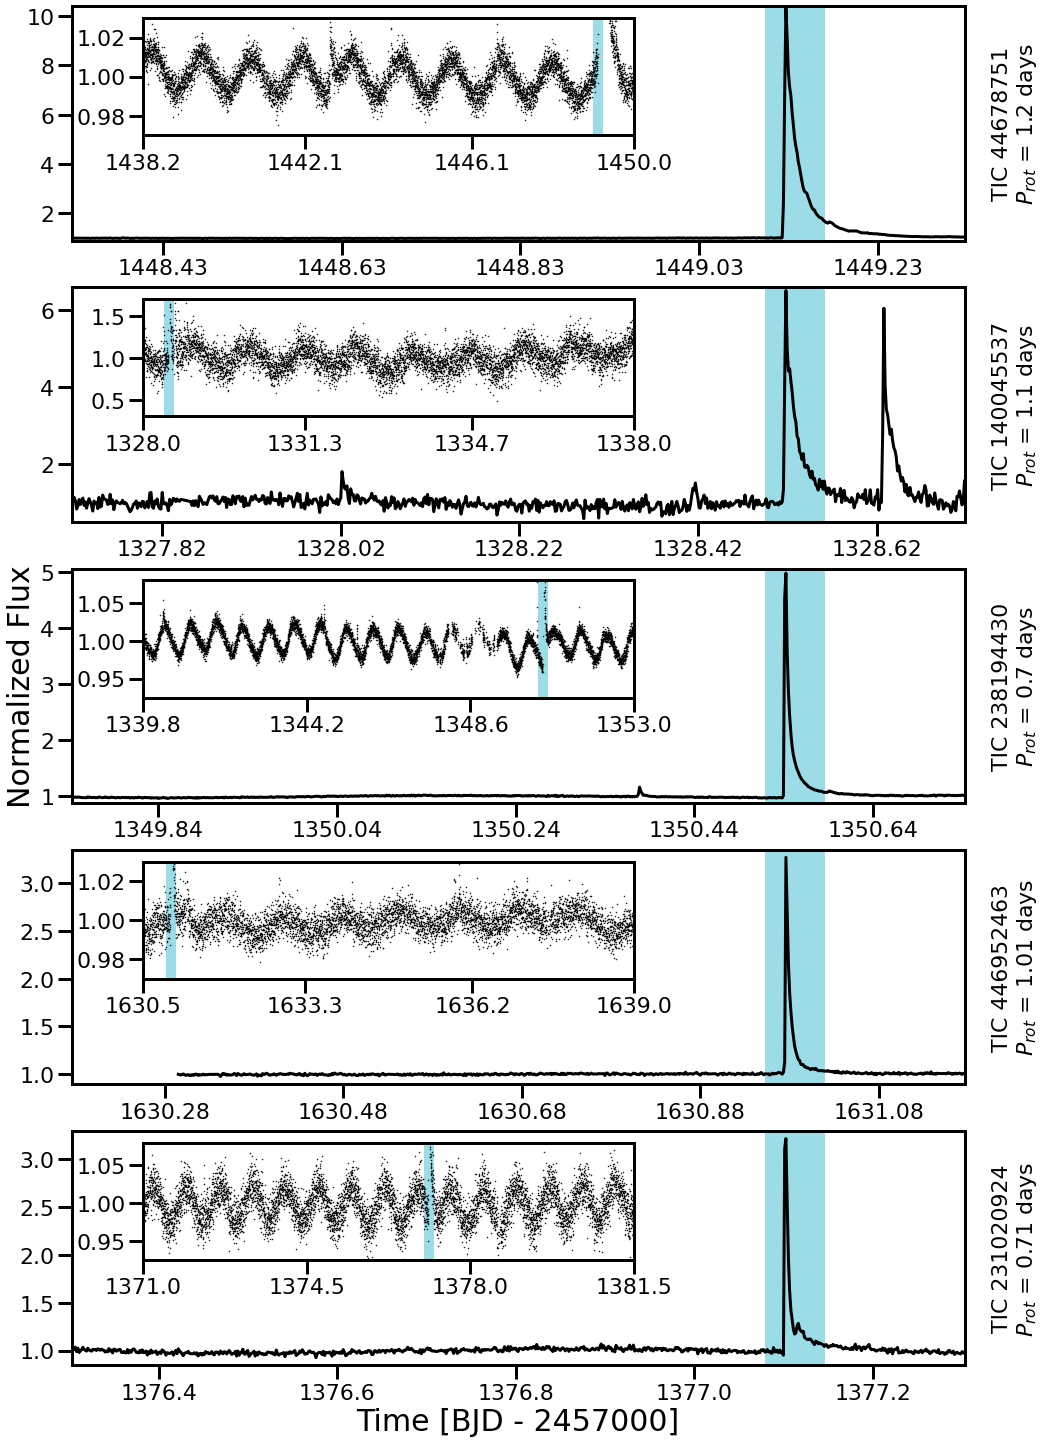

In [67]:
fig, axes = plt.subplots(figsize=(16,25), nrows=5)
fig.set_facecolor('w')
ax = axes.reshape(-1)
inds = [0,1,2,5,6]#,5]

for x,i in enumerate(inds):
    ind = np.where(megaflares['TIC_ID'][i]==tic_tracker)[0][0]
    print(ind)

    for n in [megaflares['tpeak'][i]-2457000]:
        
        left, bottom, width, height = [0.08, 0.45, 0.55, 0.5]
        ax2 = ax[x].inset_axes([left, bottom, width, height])
        ax2.plot(lk[ind].time.value, lk[ind].flux.value,'k.',ms=1)
        ax2.vlines(n+0.01,0,100,lw=10,color=parula[100],alpha=0.4)
        ax2.set_ylim(np.nanmin(lk[ind].flux.value),1.08)
        
        if i == 0:
            ax2.set_xlim(1438.2,1450.)
            ax2.set_xticks(np.round(np.linspace(1438.2,1450.,4),1))
            ax2.set_ylim(0.97,1.03)
            ax2.set_yticks(np.round(np.linspace(0.98,1.02,3),2))
        elif i == 1:
            ax2.set_xlim(1328,1338)
            ax2.set_xticks(np.round(np.linspace(1328,1338,4),1))
            ax2.set_ylim(0.3,1.7)
        elif i == 2:
            ax2.set_xlim(1339.8,1353)
            ax2.set_xticks(np.round(np.linspace(1339.8,1353,4),1))
        elif i == 5:
            ax2.set_xlim(1630.5,1639.)
            ax2.set_xticks(np.round(np.linspace(1630.5,1639.,4),1))
            ax2.set_ylim(0.97,1.03)
            ax2.set_yticks(np.round(np.linspace(0.98,1.02,3),2))
        elif i == 6:
            ax2.set_xlim(1371,1381.5)
            ax2.set_xticks(np.round(np.linspace(1371,1381.5,4),1))
        
        q = ((lk[ind].time.value>=n-0.8) & (lk[ind].time.value<=n+0.2))
    ax[x].plot(lk[ind].time.value[q], lk[ind].flux.value[q],c='k',lw=3)
    ax[x].set_xlim(n-0.8,n+0.2)
    ax[x].set_xticks(np.round(np.arange(n-0.7,n+0.3,0.2),2))
    ax[x].set_xticklabels([str(e) for e in np.round(np.arange(n-0.7,n+0.3,0.2),2)])
    ax[x].vlines(n+0.01,0,100,lw=60,color=parula[100],alpha=0.4)
    ax[x].set_ylim(np.nanmin(lk[ind].flux.value[q])-0.08, 
                   np.nanmax(lk[ind].flux.value[q])+0.08)
    ax[x].set_rasterized(True)
        
    sec = ax[x].secondary_yaxis('right')
    sec.set_yticks([])
    sec.set_ylabel('\nTIC {}'.format(megaflares['TIC_ID'][i]) + 
                   '\n$P_{rot}$ = ' + str(np.round(megaflares['Prot'][i],2)) + ' days')
    
ax[-3].set_ylabel('Normalized Flux', fontsize=30)
ax[-1].set_xlabel('Time [BJD - 2457000]', fontsize=30)
plt.savefig('/Users/arcticfox/Desktop/lightcurves.pdf',dpi=300,rasterize=True,
           bbox_inches='tight')

## Rotation period plot

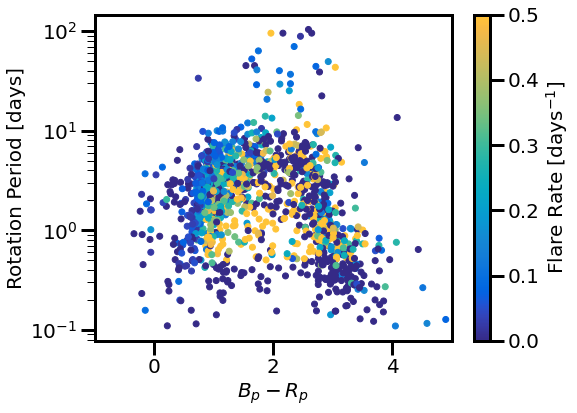

In [13]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('w')
plt.scatter(mgun['bp']-mgun['rp'], 
            mgun['period_days'], 
            c=mgun['flare_rates'], 
            vmin=0, vmax=0.5,
            cmap=parula_map)
plt.yscale('log')
plt.ylabel('Rotation Period [days]')
plt.xlabel('$B_p - R_p$')
plt.xlim(-1,5)
plt.colorbar(label='Flare Rate [days$^{-1}$]')
#plt.savefig('/Users/arcticfox/Desktop/rots.pdf',dpi=250,rasterize=True,
#           bbox_inches='tight')

In [14]:
np.nanmin(mgun['bp']-mgun['rp']), np.nanmax(mgun['bp']-mgun['rp'])

(-9.051950000000001, 11.38116)

## Fitting the Flare Frequency Distributions

In [15]:
def slope_fit(x, n, i=0, j=1, plot=False, init=[-1.5,-2], 
              bounds=((-10.0, 10.0), (-1000, 1000))):
    
    logx = np.log10(x)
    logn = np.log10(n)
    q = ((np.isnan(logn) == False) & (np.isfinite(logn)==True))
    
    if plot:
        plt.plot(logx[i:j], np.log10(n[i:j]), '.', c='k')
        plt.plot(logx[i:j], linear(init, logx[i:j]), '--', c='g', linewidth=3)

    try:
        results = minimize(linear_fit, x0=init,
                           args=(logx[q][i:j-1]-np.diff(logx[q][i:j])/2.,
                                 logn[q][i:j-1], 
                                 np.sqrt(logn[q][i:j-1]) ),
                           bounds=bounds,
                           method='L-BFGS-B', tol=1e-8)
        results.x[1] = 10**results.x[1]

        results2 = leastsq(power_law_resid, results.x,
                       args=(x[q][i:j-1]-np.diff(x[q][i:j])/2.,
                             n[q][i:j-1],
                             np.sqrt(n[q][i:j-1]) ),
                       full_output=True)
    except:
        print(len(np.diff(logx[q][i:j])), len(logx[q][i:j-1]))
        results = minimize(linear_fit, x0=init,
                           args=(logx[q][i+1:j-1]-np.diff(logx[q][i:j])/2.,
                                 logn[q][i+1:j-1], 
                                 np.sqrt(logn[q][i+1:j-1]) ),
                           bounds=bounds,
                           method='L-BFGS-B', tol=1e-8)

        results.x[1] = 10**results.x[1]

        results2 = leastsq(power_law_resid, results.x,
                       args=(x[q][i+1:j-1]-np.diff(x[q][i:j])/2.,
                             n[q][i+1:j-1],
                             np.sqrt(n[q][i+1:j-1]) ),
                       full_output=True)
    
    fit_params = results2[0]
    
    slope_err = np.sqrt(results2[1][0][0])


    model = linear([fit_params[0], np.log10(fit_params[1])], logx)
    
    if plot:
        plt.plot(logx, model, c='r')
        plt.title('{} $\pm$ {}'.format(np.round(fit_params[0],2),
                                   np.round(slope_err,2)))
        plt.show()
    
    return fit_params[0], slope_err, n, results.x[1], x, 10**model, np.log10(fit_params[1])

### Amplitude Binning 

In [16]:
bins = np.logspace(np.log10(1), np.log10(500),20)
cut = 3

array([  1.        ,   1.38691886,   1.92354391,   2.66779933,
         3.70002119,   5.13162916,   7.11715325,   9.87091404,
        13.69015682,  18.98713664,  26.33361783,  36.52259114,
        50.65387034,  70.25280792,  97.43494403, 135.13436117,
       187.42039367, 259.93687807, 360.51135771, 500.        ])

In [18]:
outslow = []
outfast = []

for t in [medlim, upplim, lowlim]:

    os = plt.hist(t[t['Prot']>=cut]['amp']*100, 
             bins=bins, 
             weights=np.full(len(t[t['Prot']>=cut]['amp']),
                     1.0/np.nansum(t[t['Prot']>=cut]['Total_obs_time']*
                                   t[t['Prot']>=cut]['prob'])))
    outslow.append(os)

    of = plt.hist(t[t['Prot']<cut]['amp']*100, 
             bins=bins, color=parula[100],
             weights=np.full(len(t[t['Prot']<cut]['amp']),
                     1.0/np.nansum(t[t['Prot']<cut]['Total_obs_time']*
                                   t[t['Prot']<cut]['prob'])))
    outfast.append(of)
    
plt.close()

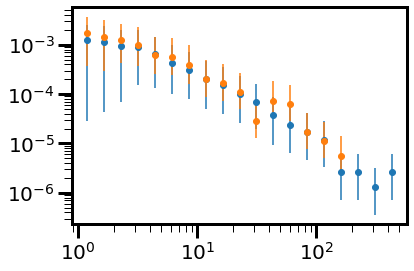

In [19]:
plt.errorbar((outfast[0][1][1:]+outfast[0][1][:-1])/2,
                 outfast[0][0],
             yerr=(outfast[1][0], outfast[2][0]), marker='o',
             linestyle='')
plt.errorbar((outslow[0][1][1:]+outslow[0][1][:-1])/2,
                 outslow[0][0],
             yerr=(outslow[1][0], outslow[2][0]), marker='o',
             linestyle='')
plt.yscale('log')
plt.xscale('log')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


15 16


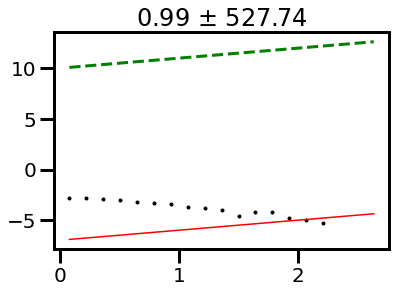

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


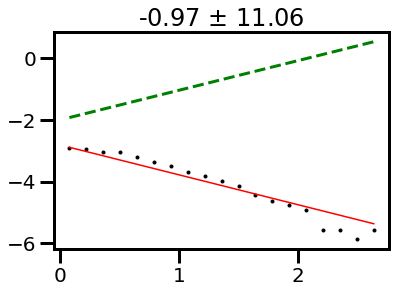

15 16


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


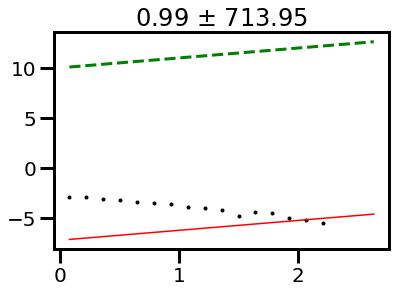

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


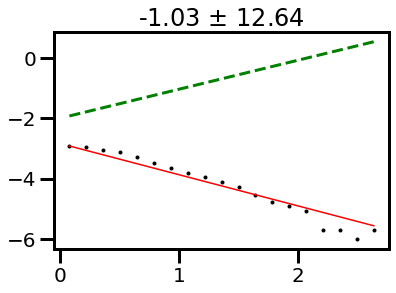

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


15 16


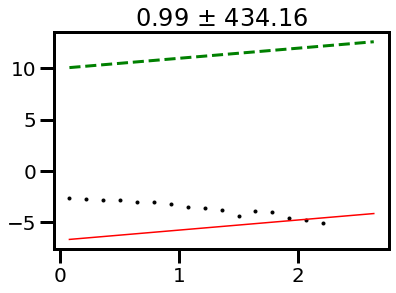

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


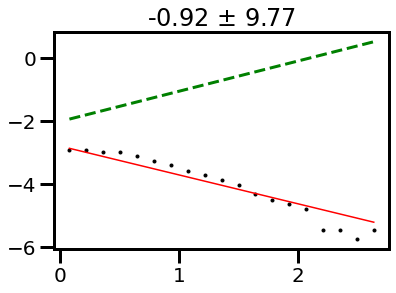

In [20]:
fitslow, fitfast = [], []

for i in range(len(outslow)):
    fl = slope_fit((outslow[i][1][1:]+outslow[i][1][:-1])/2,
                    outslow[i][0],
                    i=0,
                    j=len(outslow[i][0]),
                    plot=True, init=[0.988,10],
                    bounds=((0.988-0.0076,0.988+0.0077), (-100, 100)))

    ff = slope_fit((outfast[i][1][1:]+outfast[i][1][:-1])/2,
                    outfast[i][0],
                    i=0,j=len(outfast[i][0]),
                    plot=True, init=[0.961,-2],
                    bounds=((0.961-0.0058,0.961+0.0060), (-100, 100)))
    fitslow.append(fl)
    fitfast.append(ff)

In [47]:
samples_short = np.load('/Users/arcticfox/Downloads/short_period.npy')
samples_long = np.load('/Users/arcticfox/Downloads/long_period.npy')

slow_dist = np.nanpercentile(samples_long[:,0], [5,50,95])
slow_dist[0]=slow_dist[1]-slow_dist[0]
slow_dist[2]=slow_dist[2]-slow_dist[1]
fast_dist = np.nanpercentile(samples_short[:,0], [5,50,95])
fast_dist[0]=fast_dist[1]-fast_dist[0]
fast_dist[2]=fast_dist[2]-fast_dist[1]

In [174]:
def pdf(a, q, astar):
    norm = a0**(q-1) / mp.mpf(expint(q, a0/astar))
    return norm * a**-q * np.exp(-a/astar)

a0 = np.amin(mark_tab['amp'])
asamp = np.logspace(np.log10(0.001), np.log10(1000),100)
size = 500
short_samp_pdf = np.zeros((size,len(asamp)))
long_samp_pdf  = np.zeros((size,len(asamp)))

schoices = np.random.choice(np.arange(0,len(samples_short),1,dtype=int),
                            len(samples_short),replace=False)
lchoices = np.random.choice(np.arange(0,len(samples_long),1,dtype=int),
                            len(samples_long),replace=False)

for i in range(size):
    short_samp_pdf[i] = pdf(asamp, 
                            samples_short[schoices[i]][0], 
                            10**samples_short[i][1]*100)
    long_samp_pdf[i] = pdf(asamp,
                           samples_long[lchoices[i]][0],
                           10**samples_long[i][1]*100)

In [175]:
pdf_short = np.percentile(short_samp_pdf, [2.5,5,16,50,84,95,97.5], axis=0)
pdf_long  = np.percentile(long_samp_pdf,  [2.5,5,16,50,84,95,97.5], axis=0)

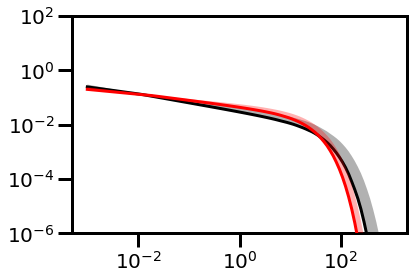

In [176]:
plt.plot(asamp, asamp*pdf_long[1],
        'k', lw=3,zorder=4, label=label)
plt.fill_between(asamp, 
                 y1=asamp*pdf_long[0], 
                 y2=asamp*pdf_long[-1],
                 lw=0, color='k', alpha=0.3, zorder=4)

plt.plot(asamp, asamp*pdf_short[1],
        'r', lw=3,zorder=4, label=label)
plt.fill_between(asamp, 
                 y1=asamp*pdf_short[0], 
                 y2=asamp*pdf_short[-1],
                 lw=0, color='r', alpha=0.3, zorder=4)
#plt.xlim([1e-2,3])
plt.ylim([1e-6,100])
plt.yscale('log')
plt.xscale('log')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


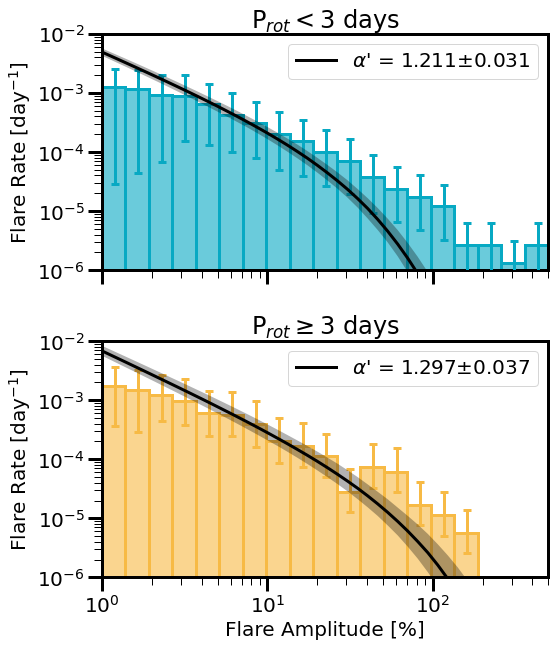

In [186]:
fig, (ax2,ax3)=plt.subplots(nrows=2,figsize=(8,10),sharex=True,sharey=True)
fig.set_facecolor('w')

c1=210
c2=100

ax3.hist(medlim[medlim['Prot']>=cut]['amp']*100, 
         bins=bins, color=parula[c1],
         weights=np.full(len(medlim[medlim['Prot']>=cut]['amp']),
                 1.0/np.nansum(medlim[medlim['Prot']>=cut]['Total_obs_time']*
                               medlim[medlim['Prot']>=cut]['prob'])),
                 alpha=0.6)

ax3.errorbar((outslow[0][1][1:]+outslow[0][1][:-1])/2,
                 outslow[0][0],
             yerr=(outslow[1][0], outslow[2][0]), marker='',
             linestyle='', color=parula[c1], capsize=4, lw=3, 
             capthick=3, zorder=3)

label = str(np.round(slow_dist[0],4)) + '$_{-'+str(np.round(slow_dist[1],4))
label += '}^{+'+str(np.round(slow_dist[2],3))+'}$'
label = r"$\alpha$' = "  + label
label = r"$\alpha$' = "  + str(np.round(slow_dist[1],3)) + '$\pm$' + str(np.round(slow_dist[0],3))

x = np.append(1,(outslow[0][1][1:]+outslow[0][1][:-1])/2)
x = np.append(x,1000)
N = 5
ax3.plot(asamp, pdf_long[3]/N,#*asamp,
        'k', lw=3,zorder=4, label=label)
ax3.fill_between(asamp, 
                 y1=pdf_long[0]/N,#*asamp, 
                 y2=pdf_long[-1]/N,#*asamp,
                 lw=0, color='k', alpha=0.3, zorder=4)

ax3.hist(medlim[medlim['Prot']>=cut]['amp']*100, 
         bins=bins, color=parula[c1],
         weights=np.full(len(medlim[medlim['Prot']>=cut]['amp']),
                 1.0/np.nansum(medlim[medlim['Prot']>=cut]['Total_obs_time']*
                               medlim[medlim['Prot']>=cut]['prob'])),
        histtype='bar', fill=None,edgecolor=parula[c1],lw=3)
ax3.set_title('P$_{rot} \geq$'+str(cut)+ ' days')

ax2.hist(medlim[medlim['Prot']<cut]['amp']*100, 
         bins=bins, color=parula[c2],
         weights=np.full(len(medlim[medlim['Prot']<cut]['amp']),
                 1.0/np.nansum(medlim[medlim['Prot']<cut]['Total_obs_time']*
                               medlim[medlim['Prot']<cut]['prob'])),
                 alpha=0.6)
ax2.hist(medlim[medlim['Prot']<cut]['amp']*100, 
         bins=bins, color=parula[c2],
         weights=np.full(len(medlim[medlim['Prot']<cut]['amp']),
                 1.0/np.nansum(medlim[medlim['Prot']<cut]['Total_obs_time']*
                               medlim[medlim['Prot']<cut]['prob'])),
        histtype='bar', fill=None, lw=3, edgecolor=parula[c2])

ax2.errorbar((outfast[0][1][1:]+outfast[0][1][:-1])/2,
                 outfast[0][0],
             yerr=(outfast[1][0], outfast[2][0]), marker='',
             linestyle='', color=parula[c2], capsize=4, lw=3,
             capthick=3, zorder=3)

label = str(np.round(fast_dist[0],4)) + '$_{-'+str(np.round(fast_dist[1],4))
label += '}^{+'+str(np.round(fast_dist[2],4))+'}$'
label = r"$\alpha$' = "  + label

label = r"$\alpha$' = " + str(np.round(fast_dist[1],3)) + '$\pm$' + str(np.round(fast_dist[0],3))

x = np.append(1,(outfast[0][1][1:]+outfast[0][1][:-1])/2)
x = np.append(x,1000)
N = 10
ax2.plot(asamp, pdf_short[3]/N,#*asamp,
        'k', lw=3,zorder=4, label=label)
ax2.fill_between(asamp, 
                 y1=pdf_short[0]/N,#*asamp, 
                 y2=pdf_short[-1]/N,#*asamp,
                 lw=0, color='k', alpha=0.3, zorder=4)

ax2.set_title('P$_{rot} <$'+str(cut)+ ' days')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax2.set_ylabel('Flare Rate [day$^{-1}$]')
ax3.set_ylabel('Flare Rate [day$^{-1}$]')
ax3.set_xlabel('Flare Amplitude [%]')
plt.subplots_adjust(hspace=0.3)
plt.xlim(1,500)
plt.ylim(1e-6,1e-2)
ax2.legend()
ax3.legend()
plt.savefig('/Users/arcticfox/Desktop/hist_rots.pdf',
            dpi=250,rasterize=True,
           bbox_inches='tight')